
# Associate Ca2+ signal with spindles for each session & subsessions using crossregistration

Load packages

In [1]:
cd "C:/Users/Manip2/SCRIPTS/Code python audrey/code python aurelie/interfaceJupyter/minian"

C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian


In [2]:
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy.interpolate import interp2d
import pickle
import os
from scipy.interpolate import griddata

%matplotlib widget

from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer
from IPython.display import display
from ipyfilechooser import FileChooser


from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

Load sleep score and Ca2+ time series numpy arrays

In [3]:
dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try:
    %store -r dpath
except:
    print("data not in strore")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
    dpath ="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"

# Set up Initial Basic Parameters#
minian_path = "."

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Folder with videos</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recordi…

In [8]:
folder_base = Path(dpath)

nb_sessions = sum(1 for p in folder_base.iterdir() if p.is_dir() and p.name.startswith("session"))
try:
    mfile = open(folder_base / f'mappingsAB.pkl', 'rb')
    mapping = pickle.load(mfile)
    print('mappingsAB.pkl opened')
except:
    mfile = open(folder_base / f'mappings.pkl', 'rb')
    mapping = pickle.load(mfile)
    print('mappings.pkl opened')

sessions = []
subsessions = []
nb_minian_total=0
dict_Calcium = {}
dict_Spike = {}
dict_SWRprop = {}
dict_Spindleprop = {}
dict_Stamps = {}
dict_StampsMiniscope = {}
dict_TodropFile = {}

for y in range(1, nb_sessions+1):
    session= 'session' + str(y)
    print(session)
    sessions.append(session)
    folder_mini = folder_base / f'session{y}/V4_Miniscope'
    nb_subsessions = sum(1 for p in folder_mini.iterdir() if p.is_dir() and p.name.startswith("session"))
    SWRproperties = folder_base / f'session{y}/OpenEphys/SWRproperties_AB.csv'
    Spindleproperties_PFC = folder_base / f'session{y}/OpenEphys/Spindlesproperties_PFC_AB.csv'
    StampsFile = folder_base / f'session{y}/SynchroFile.xlsx'
    StampsMiniscopeFile = folder_mini / f'timeStamps.csv'
    if nb_subsessions!=0:
        for x in range(1, nb_subsessions+1):            
            subsession= "session"  + str(y) + str(x)
            subsessions.append(subsession)    
            minian_ds = open_minian(folder_mini / subsession / f'minian')      # OR minianAB
            dict_Calcium[subsession] = minian_ds['C'] # calcium traces 
            dict_Spike[subsession] = minian_ds['S'] # estimated spikes
            dict_SWRprop[subsession]  = pd.read_csv(SWRproperties)
            dict_Spindleprop[subsession]  = pd.read_csv(Spindleproperties_PFC)
            dict_Stamps[subsession]  = pd.read_excel(StampsFile)
            dict_StampsMiniscope[subsession]  = pd.read_csv(StampsMiniscopeFile)
            try:
                TodropFile = folder_mini / subsession / f'minian/TodropFileAB.json'
                with open(TodropFile, 'r') as f:
                    unit_to_drop = json.load(f)
                    dict_TodropFile[subsession]  = unit_to_drop
            except:
                TodropFile = folder_mini / subsession / f'minian/TodropFile.json'
                with open(TodropFile, 'r') as f:
                    unit_to_drop = json.load(f)
                    dict_TodropFile[subsession]  = unit_to_drop
            nb_minian_total+=1
            print(nb_minian_total)
    else:
        minian_ds = open_minian(folder_mini / f'minian')            # OR minianAB
        dict_Calcium[session] = minian_ds['C'] # calcium traces 
        dict_Spike[session] = minian_ds['S'] # estimated spikes
        dict_SWRprop[session]  = pd.read_csv(SWRproperties)
        dict_Spindleprop[session]  = pd.read_csv(Spindleproperties_PFC)
        dict_Stamps[session]  = pd.read_excel(StampsFile)
        dict_StampsMiniscope[session]  = pd.read_csv(StampsMiniscopeFile)
        try:
            TodropFile = folder_mini / f'minian/TodropFileAB.json'
            with open(TodropFile, 'r') as f:
                unit_to_drop = json.load(f)
                dict_TodropFile[session]  = unit_to_drop
        except:
            TodropFile = folder_mini / f'minian/TodropFile.json'
            with open(TodropFile, 'r') as f:
                unit_to_drop = json.load(f)
                dict_TodropFile[session]  = unit_to_drop
        nb_minian_total+=1  
        print(nb_minian_total)

mappingsAB.pkl opened
session1


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

1
session2


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

2
session3


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

3
session4


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

4


Cross registration results

In [9]:
B = mapping['session']
for c in range(len(B)):
    print('unit n°', c)
    for sess in list(dict_Stamps.keys()):
        print('= unit', int(B[sess][c]), 'in', sess) if math.isnan (float(B[sess][c])) == False else None

unit n° 0
= unit 12 in session1
= unit 62 in session2
= unit 17 in session3
= unit 24 in session4
unit n° 1
= unit 10 in session1
= unit 43 in session2
= unit 12 in session3
unit n° 2
= unit 16 in session1
= unit 86 in session2
unit n° 3
= unit 3 in session1
= unit 19 in session2
= unit 1 in session3
= unit 11 in session4
unit n° 4
= unit 14 in session1
= unit 64 in session2
= unit 20 in session3
= unit 25 in session4
unit n° 5
= unit 9 in session1
= unit 37 in session2
= unit 9 in session3
= unit 18 in session4
unit n° 6
= unit 91 in session2
= unit 24 in session3
unit n° 7
= unit 35 in session2
= unit 7 in session3
unit n° 8
= unit 59 in session2
= unit 15 in session3
unit n° 9
= unit 20 in session2
= unit 3 in session3
unit n° 10
= unit 88 in session2
= unit 23 in session3
unit n° 11
= unit 38 in session2
= unit 10 in session3
unit n° 12
= unit 100 in session2
= unit 26 in session3
unit n° 13
= unit 0 in session1
unit n° 14
= unit 103 in session2
unit n° 15
= unit 40 in session2
uni

In [10]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0
    if pos == len(myList):
        return len(myList)
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def take_closest2(myList, myNumber):
    value2 = 10000000
    for ind in range(len(myList)):
        value = abs(myList[ind]-myNumber)
        if value < value2:
            value2 = value
            index = myList[ind]
    return index


def take_closest3(myList, myNumber):
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        dummy = myList.index(after)
        return dummy
    else:
        dummy = myList.index(before)
        return dummy
    

def is_between(myList, starttime, endtime):
    IsTrue='False'
    for ind in range(len(myList)):
        if starttime <= myList[ind] <= endtime:
            IsTrue='True'
    return IsTrue

Distribute Ca2+ intensity & spikes to vigilance state for each sessions/subsessions

In [7]:
data = {}
Struct = "PFC"
before = 1000 # Max distance in ms between a SWR and a spindle to be considered as Precoupled
after = 1000 # Max distance in ms between a spindle and a SWR to be considered as Postcoupled
duration = .5 # number of sec before and after the Spdl onset taken into acount
counter=0
counter2=0
Spindles_GlobalResults= pd.DataFrame(data, columns=['Mice', 'Session','Session_Time','Unique_Unit','UnitNumber','UnitValue','SpdlStatut','SpdlNumber','SpdlDuration (ms)','SWR inside Spdl','CalciumActivityPreference', 'CalciumActivityBefore','CalciumActivityAfter','AUC_calciumBefore','AUC_calciumAfter','SpikeActivityPreference','SpikeActivityBefore','SpikeActivityAfter','AUC_spikeBefore', 'AUC_spikeAfter'])
SWR_GlobalResults= pd.DataFrame(data, columns=['Mice', 'Session','Session_Time','Unique_Unit','UnitNumber','UnitValue','SWRStatut','SWRNumber','SWRDuration (ms)','SWR inside Spdl','CalciumActivityPreference', 'CalciumActivityBefore','CalciumActivityAfter','AUC_calciumBefore','AUC_calciumAfter','SpikeActivityPreference','SpikeActivityBefore','SpikeActivityAfter','AUC_spikeBefore', 'AUC_spikeAfter'])

dict_All_ActivityCa_PFCspin={}
dict_All_ActivityCa_PFCspin_Precoupled={}
dict_All_ActivityCa_PFCspin_Postcoupled={}
dict_All_ActivityCa_PFCspin_Uncoupled={}

dict_All_ActivityCa_swr={}
dict_All_ActivityCa_swr_Precoupled={}
dict_All_ActivityCa_swr_Postcoupled={}
dict_All_ActivityCa_swr_Uncoupled={}

for i in list(dict_Stamps.keys()):
    
    # Start time & freq miniscope
    StartTime = list(dict_Stamps[i][0])[0] # in seconds
    minian_freq=list(dict_Stamps[i][0])[2] # in Hz

    # start time session 2
    def Convert(string):
        li = list(string.split(", "))
        li2 = len(li)
        return li2
    stri = dict_Stamps[i][0][3]
    numbdropfr = Convert(stri)

    from ast import literal_eval
    list_droppedframes = literal_eval(dict_Stamps[i][0][3])

    First_frame = StartTime*minian_freq 
    C=dict_Calcium[i]
    Cupd = C.loc[:, First_frame:]
    rec_dur = Cupd.shape[1]
    S=dict_Spike[i] 
    Supd = S.loc[:, First_frame:]
    
    if len(list_droppedframes) > 0:
        numbdropfr = len(list(item for item in range(numbdropfr) if list_droppedframes[item] < rec_dur))
    else:
        numbdropfr = 0
    EndTime = StartTime + ((rec_dur + numbdropfr)/minian_freq) # in seconds

    PFCspipropO=dict_Spindleprop[i]
    PFCspipropM=PFCspipropO.copy()
    SWRpropO=dict_SWRprop[i]
    SWRpropM=SWRpropO.copy()
    PFCspipropM[["peak time", "start time", "end time"]] = PFCspipropM[["peak time", "start time", "end time"]]-(StartTime*1000)
    SWRpropM[["peak time", "start time", "end time"]] = SWRpropM[["peak time", "start time", "end time"]]-(StartTime*1000)

    AA = C['unit_id']
    copyAA = list(AA.copy())
    unit_to_drop=dict_TodropFile[i]    
    for u in unit_to_drop:
        copyAA.remove(u)
    unit_to_keep = copyAA
    Cupd = Cupd.loc[unit_to_keep,:]
    Supd = Supd.loc[unit_to_keep,:]
    nb_unit = Cupd.shape[0]
    print('In', i, ', kept values =', Cupd['unit_id'].values)

    # Remove Spindles that are not included in that miniscope recording
    StartTimeIndexSpi = take_closest3(list(PFCspipropM["start time"]), StartTime*1000)
    EndTimeIndexSpi = take_closest3(list(PFCspipropM["start time"]), EndTime*1000)
    if StartTimeIndexSpi > len(list(PFCspipropM["start time"])):
        StartTimeIndexSpi = 0
    if EndTimeIndexSpi > len(list(PFCspipropM["start time"])): 
        EndTimeIndexSpi = len(list(PFCspipropM["start time"]))
    PFCspipropTrunc = PFCspipropM[StartTimeIndexSpi:EndTimeIndexSpi]

    # Remove SWR that are not included in that miniscope recording
    StartTimeIndexSWR = take_closest3(list(SWRpropM["start time"]), StartTime*1000)
    EndTimeIndexSWR = take_closest3(list(SWRpropM["start time"]), EndTime*1000)
    if StartTimeIndexSWR > len(list(SWRpropM["start time"])): 
        StartTimeIndexSWR = 0
    if EndTimeIndexSWR > len(list(SWRpropM["start time"])):
        EndTimeIndexSWR = len(list(SWRpropM["start time"]))
    SWRpropTrunc = SWRpropM[StartTimeIndexSWR:EndTimeIndexSWR]

    Cseries = Cupd.to_series()
    C_upd_unit_id = Cupd['unit_id'].values
    Sseries = Supd.to_series()

    time = range(duration*2*minian_freq)
    Half = duration*minian_freq
    TimeStamps_miniscope=list(dict_StampsMiniscope[i]["Time Stamp (ms)"] + (StartTime*1000))

    units = range(nb_unit)
    nb_spindle = PFCspipropTrunc.shape[0]
    nb_swr = SWRpropTrunc.shape[0]
    print('... with', nb_spindle, 'spindles and', nb_swr, 'SWR detected')
    for unit in units:
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        lSseries = np.array(Sseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        ActivityCa_PFCspin = [] #For each unit  
        ActivityCa_PFCspin_Precoupled= [] #For each unit 
        ActivityCa_PFCspin_Postcoupled= [] #For each unit 
        ActivityCa_PFCspin_Uncoupled= [] #For each unit 
        startSpiList = list(pd.Series(PFCspipropTrunc["start time"]))
        endSpiList = list(pd.Series(PFCspipropTrunc["end time"]))
        for Pspin in range(nb_spindle): 

            # Get the calcium and spike trace associated with the spdl
            startSpi=startSpiList[Pspin]
            endSpi=endSpiList[Pspin]
            Frame_Spindle_start = take_closest2(TimeStamps_miniscope, startSpi)
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            CaTrace = list(lCseries[index-Half:index+Half])
            SpTrace = list(lSseries[index-Half:index+Half])            
            if len(CaTrace)<len(time): 
                print("Spindle too close to the begining/end of the recording,", i, ", Spdl n°", Pspin, ", Start Spdl =", int(startSpi), "ms, Start Rec =", int(Frame_Spindle_start), 'ms')
            else:
                ActivityCa_PFCspin.append(CaTrace)

                # Define if that spindle is coupled with a SWR or not
                Spdl_statut=[]
                startSWRList = list(pd.Series(SWRpropTrunc["start time"]))
                startClosest_SWR = take_closest2(startSWRList, startSpi)# + StartTimeIndexSpi])
                distance = startClosest_SWR - startSpi#  + StartTimeIndexSpi]
                if (distance > (- before)) and (distance <  0):
                    Spdl_statut = ['PreCoupled']
                    ActivityCa_PFCspin_Precoupled.append(CaTrace)
                elif (distance > (0)) and (distance <  after):
                    Spdl_statut = ['PostCoupled']
                    ActivityCa_PFCspin_Postcoupled.append(CaTrace)
                else:
                    Spdl_statut= ['UnCoupled']
                    ActivityCa_PFCspin_Uncoupled.append(CaTrace)

                Spindles_GlobalResults.loc[counter, 'Mice'] = os.path.basename(folder_base)
                Spindles_GlobalResults.loc[counter, 'Session'] = i 
                Spindles_GlobalResults.loc[counter, 'Session_Time'] = None 
                indexMapp = np.where(B[i] == C_upd_unit_id[unit])[0]
                Spindles_GlobalResults.loc[counter, 'Unique_Unit'] = indexMapp 
                Spindles_GlobalResults.loc[counter, 'UnitNumber'] = unit 
                Spindles_GlobalResults.loc[counter, 'UnitValue'] = C_upd_unit_id[unit] 
                Spindles_GlobalResults.loc[counter, 'SpdlStatut'] = Spdl_statut
                Spindles_GlobalResults.loc[counter, 'SpdlNumber'] = Pspin
                Spindles_GlobalResults.loc[counter, 'SpdlDuration (ms)'] = endSpi- startSpi
                IsTrue=is_between(startSWRList,startSpi, endSpi)
                Spindles_GlobalResults.loc[counter, 'SWR inside Spdl'] = IsTrue
                
                if np.mean(CaTrace[:Half],0) > np.mean(CaTrace[Half:],0):
                    pref='Before'
                elif np.mean(CaTrace[:Half],0) < np.mean(CaTrace[Half:],0):
                    pref='After' 
                else:
                    pref='None'
                Spindles_GlobalResults.loc[counter, 'CalciumActivityPreference'] = pref
                Spindles_GlobalResults.loc[counter, 'CalciumActivityBefore'] = np.mean(CaTrace[:Half],0)
                Spindles_GlobalResults.loc[counter, 'CalciumActivityAfter'] = np.mean(CaTrace[Half:],0)
                Spindles_GlobalResults.loc[counter, 'AUC_calciumBefore'] = np.trapz(CaTrace[:Half],np.arange(0,len(CaTrace[:Half]),1))
                Spindles_GlobalResults.loc[counter, 'AUC_calciumAfter'] = np.trapz(CaTrace[Half:],np.arange(0,len(CaTrace[Half:]),1))          

                if np.mean(SpTrace[:Half],0) > np.mean(SpTrace[Half:],0):
                    pref='Before'
                elif np.mean(SpTrace[:Half],0) < np.mean(SpTrace[Half:],0):
                    pref='After' 
                else:
                    pref='None'
                Spindles_GlobalResults.loc[counter, 'SpikeActivityPreference'] = pref
                Spindles_GlobalResults.loc[counter, 'SpikeActivityBefore'] = np.mean(SpTrace[:Half],0)
                Spindles_GlobalResults.loc[counter, 'SpikeActivityAfter'] = np.mean(SpTrace[Half:],0)
                Spindles_GlobalResults.loc[counter, 'AUC_spikeBefore'] = np.trapz(SpTrace[:Half],np.arange(0,len(SpTrace[:Half]),1))
                Spindles_GlobalResults.loc[counter, 'AUC_spikeAfter'] = np.trapz(SpTrace[Half:],np.arange(0,len(SpTrace[Half:]),1))
                counter+=1  

        if len(indexMapp) > 0: #not empty --> cause some units are not in the cross registration..! Need to know why 
            if str(indexMapp) in dict_All_ActivityCa_PFCspin:
                # All traces for each spindles per Unique unit (according to cross-registration)

                if np.shape(dict_All_ActivityCa_PFCspin[str(indexMapp)])[1] == np.shape(np.array(ActivityCa_PFCspin))[1]:            
                    dict_All_ActivityCa_PFCspin[str(indexMapp)] = np.append(dict_All_ActivityCa_PFCspin[str(indexMapp)], np.array(ActivityCa_PFCspin), axis=0)
                    dict_All_ActivityCa_PFCspin_Precoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_PFCspin_Precoupled[str(indexMapp)], np.array(ActivityCa_PFCspin_Precoupled), axis=0) if len(ActivityCa_PFCspin_Precoupled)>0 else None
                    dict_All_ActivityCa_PFCspin_Postcoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_PFCspin_Postcoupled[str(indexMapp)], np.array(ActivityCa_PFCspin_Postcoupled), axis=0)  if len(ActivityCa_PFCspin_Postcoupled)>0 else None
                    dict_All_ActivityCa_PFCspin_Uncoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_PFCspin_Uncoupled[str(indexMapp)], np.array(ActivityCa_PFCspin_Uncoupled), axis=0) if len(ActivityCa_PFCspin_Uncoupled)>0 else None
                else:
                    data = np.array(ActivityCa_PFCspin)
                    new_shape = (np.shape(data)[0], np.shape(dict_All_ActivityCa_PFCspin[str(indexMapp)])[1])
                    x_indices = np.arange(data.shape[1])
                    y_indices = np.arange(data.shape[0])
                    x_new_indices = np.linspace(0, data.shape[1] - 1, new_shape[1])
                    y_new_indices = np.linspace(0, data.shape[0] - 1, new_shape[0])
                    x_mesh, y_mesh = np.meshgrid(x_indices, y_indices)
                    x_new_mesh, y_new_mesh = np.meshgrid(x_new_indices, y_new_indices)
                    resampled_data = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                    dict_All_ActivityCa_PFCspin[str(indexMapp)] = np.append(dict_All_ActivityCa_PFCspin[str(indexMapp)], np.array(resampled_data), axis=0)

                    data = np.array(ActivityCa_PFCspin_Precoupled)
                    new_shape = (np.shape(data)[0], np.shape(dict_All_ActivityCa_PFCspin_Precoupled[str(indexMapp)])[1])
                    x_indices = np.arange(data.shape[1])
                    y_indices = np.arange(data.shape[0])
                    x_new_indices = np.linspace(0, data.shape[1] - 1, new_shape[1])
                    y_new_indices = np.linspace(0, data.shape[0] - 1, new_shape[0])
                    x_mesh, y_mesh = np.meshgrid(x_indices, y_indices)
                    x_new_mesh, y_new_mesh = np.meshgrid(x_new_indices, y_new_indices)
                    resampled_data = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                    dict_All_ActivityCa_PFCspin_Precoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_PFCspin_Precoupled[str(indexMapp)], np.array(resampled_data), axis=0)

                    data = np.array(ActivityCa_PFCspin_Postcoupled)
                    new_shape = (np.shape(data)[0], np.shape(dict_All_ActivityCa_PFCspin_Postcoupled[str(indexMapp)])[1])
                    x_indices = np.arange(data.shape[1])
                    y_indices = np.arange(data.shape[0])
                    x_new_indices = np.linspace(0, data.shape[1] - 1, new_shape[1])
                    y_new_indices = np.linspace(0, data.shape[0] - 1, new_shape[0])
                    x_mesh, y_mesh = np.meshgrid(x_indices, y_indices)
                    x_new_mesh, y_new_mesh = np.meshgrid(x_new_indices, y_new_indices)
                    resampled_data = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                    dict_All_ActivityCa_PFCspin_Postcoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_PFCspin_Postcoupled[str(indexMapp)], np.array(resampled_data), axis=0)

                    data = np.array(ActivityCa_PFCspin_Uncoupled)
                    new_shape = (np.shape(data)[0], np.shape(dict_All_ActivityCa_PFCspin_Uncoupled[str(indexMapp)])[1])
                    x_indices = np.arange(data.shape[1])
                    y_indices = np.arange(data.shape[0])
                    x_new_indices = np.linspace(0, data.shape[1] - 1, new_shape[1])
                    y_new_indices = np.linspace(0, data.shape[0] - 1, new_shape[0])
                    x_mesh, y_mesh = np.meshgrid(x_indices, y_indices)
                    x_new_mesh, y_new_mesh = np.meshgrid(x_new_indices, y_new_indices)
                    resampled_data = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                    dict_All_ActivityCa_PFCspin_Uncoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_PFCspin_Uncoupled[str(indexMapp)], np.array(resampled_data), axis=0)

            else:                     
                dict_All_ActivityCa_PFCspin[str(indexMapp)] = np.array(ActivityCa_PFCspin)
                dict_All_ActivityCa_PFCspin_Precoupled[str(indexMapp)] = np.array(ActivityCa_PFCspin_Precoupled) if len(ActivityCa_PFCspin_Precoupled)>0 else None
                dict_All_ActivityCa_PFCspin_Postcoupled[str(indexMapp)] = np.array(ActivityCa_PFCspin_Postcoupled) if len(ActivityCa_PFCspin_Postcoupled)>0 else None
                dict_All_ActivityCa_PFCspin_Uncoupled[str(indexMapp)] = np.array(ActivityCa_PFCspin_Uncoupled) if len(ActivityCa_PFCspin_Uncoupled)>0 else None


        ActivityCa_swr = [] #For each unit  
        ActivityCa_swr_Precoupled= [] #For each unit 
        ActivityCa_swr_Postcoupled= [] #For each unit 
        ActivityCa_swr_Uncoupled= [] #For each unit 

        startSwrList = list(pd.Series(SWRpropTrunc["start time"]))
        endSwrList = list(pd.Series(SWRpropTrunc["end time"]))
        for Pswr in range(nb_swr): 
            # Get the calcium and spike trace associated with the swr
            startSwr=startSwrList[Pswr]
            endSwr=endSwrList[Pswr]
            Frame_SWR_start = take_closest2(TimeStamps_miniscope, startSwr)
            index = TimeStamps_miniscope.index(Frame_SWR_start)
            CaTrace = list(lCseries[index-Half:index+Half])
            SpTrace = list(lSseries[index-Half:index+Half])     
            if len(CaTrace)<len(time): 
                print("SWR too close to the begining/end of the recording,", i, ", SWR n°", Pswr, ", Start SWR =",  int(startSwr), "ms, Start Rec =", int(Frame_SWR_start), 'ms')
            else:
                ActivityCa_swr.append(CaTrace) 

                # Define if that SWR is coupled with a spdl or not
                SWR_statut=[]
                startSpiList = list(pd.Series(PFCspipropTrunc["start time"]))
                endSpiList = list(pd.Series(PFCspipropTrunc["end time"]))
                startClosest_Spi = take_closest2(startSpiList, startSwr)# + StartTimeIndexSpi])
                indexSpi = startSpiList.index(startClosest_Spi)
                endClosest_Spi=endSpiList[indexSpi]
                distance = startClosest_Spi - startSwr#  + StartTimeIndexSpi]  
                IsTrue = 'False'             
                if (distance > (- before)) and (distance <  0):
                    SWR_statut = ['Postcoupled']
                    ActivityCa_swr_Postcoupled.append(CaTrace)
                    if startSwr<endClosest_Spi:
                        IsTrue = 'True' #SWR inside the Spindle
                elif (distance > (0)) and (distance <  after):
                    SWR_statut = ['Precoupled']
                    ActivityCa_swr_Precoupled.append(CaTrace)
                else:
                    SWR_statut= ['UnCoupled']
                    ActivityCa_swr_Uncoupled.append(CaTrace)

                SWR_GlobalResults.loc[counter2, 'Mice'] = os.path.basename(folder_base)
                SWR_GlobalResults.loc[counter2, 'Session'] = i 
                SWR_GlobalResults.loc[counter2, 'Session_Time'] = None 
                indexMapp = np.where(B[i] == C_upd_unit_id[unit])[0]
                SWR_GlobalResults.loc[counter2, 'Unique_Unit'] = indexMapp 
                SWR_GlobalResults.loc[counter2, 'UnitNumber'] = unit 
                SWR_GlobalResults.loc[counter2, 'UnitValue'] = C_upd_unit_id[unit] 
                SWR_GlobalResults.loc[counter2, 'SWRStatut'] = SWR_statut
                SWR_GlobalResults.loc[counter2, 'SWRNumber'] = Pswr
                SWR_GlobalResults.loc[counter2, 'SWRDuration (ms)'] = endSwr- startSwr
                SWR_GlobalResults.loc[counter2, 'SWR inside Spdl'] = IsTrue
                
                if np.mean(CaTrace[:Half],0) > np.mean(CaTrace[Half:],0):
                    pref='Before'
                elif np.mean(CaTrace[:Half],0) < np.mean(CaTrace[Half:],0):
                    pref='After' 
                else:
                    pref='None'
                SWR_GlobalResults.loc[counter2, 'CalciumActivityPreference'] = pref
                SWR_GlobalResults.loc[counter2, 'CalciumActivityBefore'] = np.mean(CaTrace[:Half],0)
                SWR_GlobalResults.loc[counter2, 'CalciumActivityAfter'] = np.mean(CaTrace[Half:],0)
                SWR_GlobalResults.loc[counter2, 'AUC_calciumBefore'] = np.trapz(CaTrace[:Half],np.arange(0,len(CaTrace[:Half]),1))
                SWR_GlobalResults.loc[counter2, 'AUC_calciumAfter'] = np.trapz(CaTrace[Half:],np.arange(0,len(CaTrace[Half:]),1))          

                if np.mean(SpTrace[:Half],0) > np.mean(SpTrace[Half:],0):
                    pref='Before'
                elif np.mean(SpTrace[:Half],0) < np.mean(SpTrace[Half:],0):
                    pref='After' 
                else:
                    pref='None'
                SWR_GlobalResults.loc[counter2, 'SpikeActivityPreference'] = pref
                SWR_GlobalResults.loc[counter2, 'SpikeActivityBefore'] = np.mean(SpTrace[:Half],0)
                SWR_GlobalResults.loc[counter2, 'SpikeActivityAfter'] = np.mean(SpTrace[Half:],0)
                SWR_GlobalResults.loc[counter2, 'AUC_spikeBefore'] = np.trapz(SpTrace[:Half],np.arange(0,len(SpTrace[:Half]),1))
                SWR_GlobalResults.loc[counter2, 'AUC_spikeAfter'] = np.trapz(SpTrace[Half:],np.arange(0,len(SpTrace[Half:]),1))
                counter2+=1  

        if len(indexMapp) > 0: #not empty --> cause some units are not in the cross registration..! Need to know why 
            if str(indexMapp) in dict_All_ActivityCa_swr:
                # All traces for each spindles per Unique unit (according to cross-registration)
                if np.shape(dict_All_ActivityCa_swr[str(indexMapp)])[1] == np.shape(np.array(ActivityCa_swr))[1]:            
                    dict_All_ActivityCa_swr[str(indexMapp)] = np.append(dict_All_ActivityCa_swr[str(indexMapp)], np.array(ActivityCa_swr), axis=0)
                    dict_All_ActivityCa_swr_Precoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_swr_Precoupled[str(indexMapp)], np.array(ActivityCa_swr_Precoupled), axis=0) if len(ActivityCa_PFCspin_Precoupled)>0 else None
                    dict_All_ActivityCa_swr_Postcoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_swr_Postcoupled[str(indexMapp)], np.array(ActivityCa_swr_Postcoupled), axis=0)  if len(ActivityCa_PFCspin_Postcoupled)>0 else None
                    dict_All_ActivityCa_swr_Uncoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_swr_Uncoupled[str(indexMapp)], np.array(ActivityCa_swr_Uncoupled), axis=0) if len(ActivityCa_PFCspin_Uncoupled)>0 else None
                else:
                    data = np.array(ActivityCa_swr)
                    new_shape = (np.shape(data)[0], np.shape(dict_All_ActivityCa_swr[str(indexMapp)])[1])
                    x_indices = np.arange(data.shape[1])
                    y_indices = np.arange(data.shape[0])
                    x_new_indices = np.linspace(0, data.shape[1] - 1, new_shape[1])
                    y_new_indices = np.linspace(0, data.shape[0] - 1, new_shape[0])
                    x_mesh, y_mesh = np.meshgrid(x_indices, y_indices)
                    x_new_mesh, y_new_mesh = np.meshgrid(x_new_indices, y_new_indices)
                    resampled_data = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                    dict_All_ActivityCa_swr[str(indexMapp)] = np.append(dict_All_ActivityCa_swr[str(indexMapp)], np.array(resampled_data), axis=0)

                    data = np.array(ActivityCa_swr_Precoupled)
                    new_shape = (np.shape(data)[0], np.shape(dict_All_ActivityCa_swr_Precoupled[str(indexMapp)])[1])
                    x_indices = np.arange(data.shape[1])
                    y_indices = np.arange(data.shape[0])
                    x_new_indices = np.linspace(0, data.shape[1] - 1, new_shape[1])
                    y_new_indices = np.linspace(0, data.shape[0] - 1, new_shape[0])
                    x_mesh, y_mesh = np.meshgrid(x_indices, y_indices)
                    x_new_mesh, y_new_mesh = np.meshgrid(x_new_indices, y_new_indices)
                    resampled_data = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                    dict_All_ActivityCa_swr_Precoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_swr_Precoupled[str(indexMapp)], np.array(resampled_data), axis=0)

                    data = np.array(ActivityCa_swr_Postcoupled)
                    new_shape = (np.shape(data)[0], np.shape(dict_All_ActivityCa_swr_Postcoupled[str(indexMapp)])[1])
                    x_indices = np.arange(data.shape[1])
                    y_indices = np.arange(data.shape[0])
                    x_new_indices = np.linspace(0, data.shape[1] - 1, new_shape[1])
                    y_new_indices = np.linspace(0, data.shape[0] - 1, new_shape[0])
                    x_mesh, y_mesh = np.meshgrid(x_indices, y_indices)
                    x_new_mesh, y_new_mesh = np.meshgrid(x_new_indices, y_new_indices)
                    resampled_data = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                    dict_All_ActivityCa_swr_Postcoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_swr_Postcoupled[str(indexMapp)], np.array(resampled_data), axis=0)

                    data = np.array(ActivityCa_swr_Uncoupled)
                    new_shape = (np.shape(data)[0], np.shape(dict_All_ActivityCa_swr_Uncoupled[str(indexMapp)])[1])
                    x_indices = np.arange(data.shape[1])
                    y_indices = np.arange(data.shape[0])
                    x_new_indices = np.linspace(0, data.shape[1] - 1, new_shape[1])
                    y_new_indices = np.linspace(0, data.shape[0] - 1, new_shape[0])
                    x_mesh, y_mesh = np.meshgrid(x_indices, y_indices)
                    x_new_mesh, y_new_mesh = np.meshgrid(x_new_indices, y_new_indices)
                    resampled_data = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                    dict_All_ActivityCa_swr_Uncoupled[str(indexMapp)] = np.append(dict_All_ActivityCa_swr_Uncoupled[str(indexMapp)], np.array(resampled_data), axis=0)
            else:                     
                dict_All_ActivityCa_swr[str(indexMapp)] = np.array(ActivityCa_swr)
                dict_All_ActivityCa_swr_Precoupled[str(indexMapp)] = np.array(ActivityCa_swr_Precoupled) if len(ActivityCa_swr_Precoupled)>0 else None
                dict_All_ActivityCa_swr_Postcoupled[str(indexMapp)] = np.array(ActivityCa_swr_Postcoupled) if len(ActivityCa_swr_Postcoupled)>0 else None
                dict_All_ActivityCa_swr_Uncoupled[str(indexMapp)] = np.array(ActivityCa_swr_Uncoupled) if len(ActivityCa_swr_Uncoupled)>0 else None


print('Nb of unique units for', os.path.basename(folder_base), '=', len(dict_All_ActivityCa_PFCspin))

In session1 , kept values = [ 3  9 10 12 14 16]
... with 18 spindles and 491 SWR detected
SWR too close to the begining/end of the recording, session1 , SWR n° 0 , Start SWR = 4188 ms, Start Rec = 4186 ms
SWR too close to the begining/end of the recording, session1 , SWR n° 0 , Start SWR = 4188 ms, Start Rec = 4186 ms
SWR too close to the begining/end of the recording, session1 , SWR n° 0 , Start SWR = 4188 ms, Start Rec = 4186 ms
SWR too close to the begining/end of the recording, session1 , SWR n° 0 , Start SWR = 4188 ms, Start Rec = 4186 ms
SWR too close to the begining/end of the recording, session1 , SWR n° 0 , Start SWR = 4188 ms, Start Rec = 4186 ms
SWR too close to the begining/end of the recording, session1 , SWR n° 0 , Start SWR = 4188 ms, Start Rec = 4186 ms
In session2 , kept values = [ 19  20  35  37  38  40  43  59  62  64  71  79  86  88  91 100 103 122]
... with 20 spindles and 339 SWR detected
In session3 , kept values = [ 1  3  5  7  9 10 11 12 15 17 18 20 23 24 26]
.

In [8]:
Spindles_GlobalResults

,Mice,Session,Session_Time,Unique_Unit,UnitNumber,UnitValue,SpdlStatut,SpdlNumber,SpdlDuration (ms),SWR inside Spdl,CalciumActivityPreference,CalciumActivityBefore,CalciumActivityAfter,AUC_calciumBefore,AUC_calciumAfter,SpikeActivityPreference,SpikeActivityBefore,SpikeActivityAfter,AUC_spikeBefore,AUC_spikeAfter
0,BlackLinesOK,session1,None,3,0,3,[PreCoupled],0,541.0,True,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0
1,BlackLinesOK,session1,None,3,0,3,[PostCoupled],1,536.0,True,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0
2,BlackLinesOK,session1,None,3,0,3,[PostCoupled],2,1000.0,True,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0
3,BlackLinesOK,session1,None,3,0,3,[UnCoupled],3,545.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0
4,BlackLinesOK,session1,None,3,0,3,[UnCoupled],4,1102.0,True,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,BlackLinesOK,session4,None,4,3,25,[UnCoupled],120,273.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0
1204,BlackLinesOK,session4,None,4,3,25,[UnCoupled],121,580.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0
1205,BlackLinesOK,session4,None,4,3,25,[UnCoupled],122,259.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0
1206,BlackLinesOK,session4,None,4,3,25,[UnCoupled],123,268.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0


Save to Excel

In [222]:
mice=os.path.basename(folder_base) 
filenameOut = folder_base / f'Spindles_GlobalResultsAB_{mice}.xlsx'
writer = pd.ExcelWriter(filenameOut)
Spindles_GlobalResults.to_excel(writer)
writer.close()

Do average results for this mouse

In [223]:
AVG_dict_All_ActivityCa_PFCspin = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_PFCspin.items()}
Array=list(AVG_dict_All_ActivityCa_PFCspin.values())

AVG_dict_All_ActivityCa_PFCspin_Uncoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_PFCspin_Uncoupled.items()}
ArrayUn=list(AVG_dict_All_ActivityCa_PFCspin_Uncoupled.values())

AVG_dict_All_ActivityCa_PFCspin_Precoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_PFCspin_Precoupled.items()}
ArrayPre=list(AVG_dict_All_ActivityCa_PFCspin_Precoupled.values())

AVG_dict_All_ActivityCa_PFCspin_Postcoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_PFCspin_Postcoupled.items()}
ArrayPost=list(AVG_dict_All_ActivityCa_PFCspin_Postcoupled.values())


In [224]:
filenameOut = folder_base / f'Spindles_AverageResultsAB_{mice}.xlsx'
excel_writer = pd.ExcelWriter(filenameOut)

Array=pd.DataFrame(Array)
ArrayUn=pd.DataFrame(ArrayUn)
ArrayPre=pd.DataFrame(ArrayPre)
ArrayPost=pd.DataFrame(ArrayPost)

Array.to_excel(excel_writer, sheet_name='All_Spindles', index=True, header=False)
ArrayUn.to_excel(excel_writer, sheet_name='Uncoupled_Spindles', index=True, header=False)
ArrayPre.to_excel(excel_writer, sheet_name='Precoupled_Spindles', index=True, header=False)
ArrayPost.to_excel(excel_writer, sheet_name='Postcoupled_Spindles', index=True, header=False)

# Save the Excel file
excel_writer.close()

In [9]:
minian_freq

20

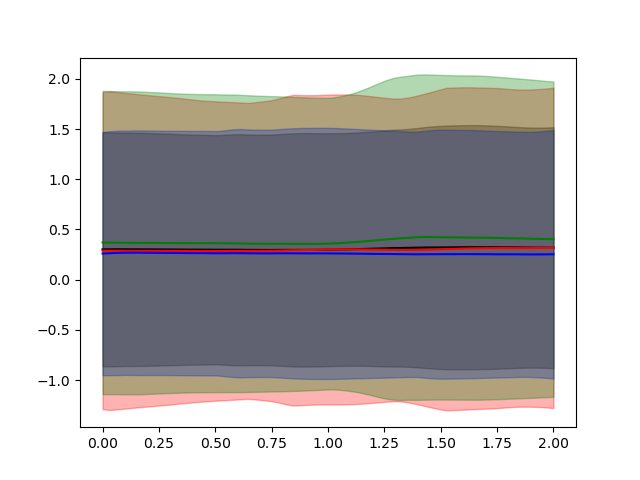

In [225]:
first_key = next(iter(dict_Stamps))
minian_freq=dict_Stamps[first_key][0][2]

x = np.linspace(0, duration*2, duration*2*minian_freq)
z_score = 1.96  # For a 95% confidence interval
plt.close()

y=Array
std_dev = np.std(y, axis=0)
mmean = np.mean(y, axis=0)
margin_of_error = z_score * std_dev
lower_bound = mmean - margin_of_error
upper_bound = mmean + margin_of_error
plt.plot(x, mmean, color='black')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.3, label='Confidence Interval', color='black')

y=ArrayUn
std_dev = np.std(y, axis=0)
mmean = np.mean(y, axis=0)
margin_of_error = z_score * std_dev
lower_bound = mmean - margin_of_error
upper_bound = mmean + margin_of_error
plt.plot(x, mmean, color='red')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.3, label='Confidence Interval', color='red')

y=ArrayPre
std_dev = np.std(y, axis=0)
mmean = np.mean(y, axis=0)
margin_of_error = z_score * std_dev
lower_bound = mmean - margin_of_error
upper_bound = mmean + margin_of_error
plt.plot(x, mmean, color='blue')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.3, label='Confidence Interval', color='blue')

y=ArrayPost
std_dev = np.std(y, axis=0)
mmean = np.mean(y, axis=0)
margin_of_error = z_score * std_dev
lower_bound = mmean - margin_of_error
upper_bound = mmean + margin_of_error
plt.plot(x, mmean, color='green')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.3, label='Confidence Interval', color='green')


plt.show()


In [226]:
SWR_GlobalResults

,Mice,Session,Session_Time,Unique_Unit,UnitNumber,UnitValue,SWRStatut,SWRNumber,SWRDuration (ms),SWR inside Spdl,CalciumActivityPreference,CalciumActivityBefore,CalciumActivityAfter,AUC_calciumBefore,AUC_calciumAfter,SpikeActivityPreference,SpikeActivityBefore,SpikeActivityAfter,AUC_spikeBefore,AUC_spikeAfter
0,ThreeColDotsOK,session11,None,354,0,5,[UnCoupled],3,53.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0
1,ThreeColDotsOK,session11,None,354,0,5,[UnCoupled],4,46.0,False,None,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0
2,ThreeColDotsOK,session11,None,354,0,5,[UnCoupled],5,57.0,False,After,0.127698,0.199086,3.717155,5.77244,Before,0.00864,0.0,0.259205,0.0
3,ThreeColDotsOK,session11,None,354,0,5,[UnCoupled],6,118.0,False,After,0.16464,0.1905,4.830323,5.523503,Before,0.00864,0.0,0.259205,0.0
4,ThreeColDotsOK,session11,None,354,0,5,[UnCoupled],7,78.0,False,After,2.857737,3.563569,83.125125,103.639948,Before,0.060043,0.040253,1.80128,1.207592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157958,ThreeColDotsOK,session34,None,332,7,86,[Postcoupled],699,55.0,True,Before,0.102078,0.073668,2.959458,2.135795,None,0.0,0.0,0.0,0.0
157959,ThreeColDotsOK,session34,None,332,7,86,[Postcoupled],700,62.0,True,Before,0.098803,0.071304,2.864488,2.067256,None,0.0,0.0,0.0,0.0
157960,ThreeColDotsOK,session34,None,332,7,86,[UnCoupled],701,46.0,False,After,0.1257,0.807208,3.559027,23.581883,After,0.011922,0.022772,0.319833,0.614318
157961,ThreeColDotsOK,session34,None,332,7,86,[UnCoupled],702,39.0,False,After,0.46361,0.871805,13.454367,25.064413,Before,0.031982,0.02468,0.959462,0.688486


In [227]:
mice=os.path.basename(folder_base) 
filenameOut = folder_base / f'SWR_GlobalResultsAB_{mice}.xlsx'
writer = pd.ExcelWriter(filenameOut)
Spindles_GlobalResults.to_excel(writer)
writer.close()

In [228]:
AVG_dict_All_ActivityCa_swr = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_swr.items()}
Array=list(AVG_dict_All_ActivityCa_swr.values())

AVG_dict_All_ActivityCa_swr_Uncoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_swr_Uncoupled.items()}
ArrayUn=list(AVG_dict_All_ActivityCa_swr_Uncoupled.values())

AVG_dict_All_ActivityCa_swr_Precoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_swr_Precoupled.items()}
ArrayPre=list(AVG_dict_All_ActivityCa_swr_Precoupled.values())

AVG_dict_All_ActivityCa_swr_Postcoupled = {key: np.mean(matrix,0) for key, matrix in dict_All_ActivityCa_swr_Postcoupled.items()}
ArrayPost=list(AVG_dict_All_ActivityCa_swr_Postcoupled.values())


In [229]:
filenameOut = folder_base / f'SWR_AverageResultsAB_{mice}.xlsx'
excel_writer = pd.ExcelWriter(filenameOut)

Array=pd.DataFrame(Array)
ArrayUn=pd.DataFrame(ArrayUn)
ArrayPre=pd.DataFrame(ArrayPre)
ArrayPost=pd.DataFrame(ArrayPost)

Array.to_excel(excel_writer, sheet_name='All_SWR', index=True, header=False)
ArrayUn.to_excel(excel_writer, sheet_name='Uncoupled_SWR', index=True, header=False)
ArrayPre.to_excel(excel_writer, sheet_name='Precoupled_SWR', index=True, header=False)
ArrayPost.to_excel(excel_writer, sheet_name='Postcoupled_SWR', index=True, header=False)

# Save the Excel file
excel_writer.close()

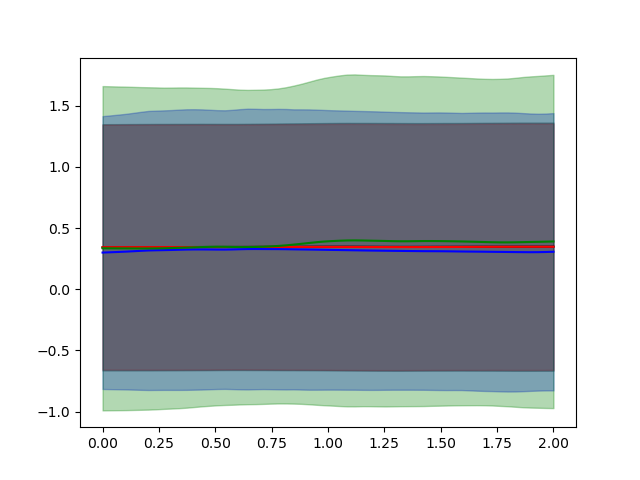

In [230]:
first_key = next(iter(dict_Stamps))
minian_freq=dict_Stamps[first_key][0][2]

x = np.linspace(0, duration*2, duration*2*minian_freq)
z_score = 1.96  # For a 95% confidence interval
plt.close()

y=Array
std_dev = np.std(y, axis=0)
mmean = np.mean(y, axis=0)
margin_of_error = z_score * std_dev
lower_bound = mmean - margin_of_error
upper_bound = mmean + margin_of_error
plt.plot(x, mmean, color='black')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.3, label='Confidence Interval', color='black')

y=ArrayUn
std_dev = np.std(y, axis=0)
mmean = np.mean(y, axis=0)
margin_of_error = z_score * std_dev
lower_bound = mmean - margin_of_error
upper_bound = mmean + margin_of_error
plt.plot(x, mmean, color='red')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.3, label='Confidence Interval', color='red')

y=ArrayPre
std_dev = np.std(y, axis=0)
mmean = np.mean(y, axis=0)
margin_of_error = z_score * std_dev
lower_bound = mmean - margin_of_error
upper_bound = mmean + margin_of_error
plt.plot(x, mmean, color='blue')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.3, label='Confidence Interval', color='blue')

y=ArrayPost
std_dev = np.std(y, axis=0)
mmean = np.mean(y, axis=0)
margin_of_error = z_score * std_dev
lower_bound = mmean - margin_of_error
upper_bound = mmean + margin_of_error
plt.plot(x, mmean, color='green')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.3, label='Confidence Interval', color='green')


plt.show()